In [1]:
# Imports
import torch
import numpy as np
import pandas as pd
import brambox as bb
import lightnet as ln
import interpretability as ip

# Settings
bb.logger.setConsoleLevel('ERROR')             # Only show error log messages

WARNING    OpenCV is not installed and cannot be used


In [2]:
# Load annotations
anno = bb.io.load('pandas', 'data/annotations.pkl')
det = bb.io.load('pandas', 'data/detections.pkl')
my_class = 'bicycle'

anno = anno[anno['class_label'] == my_class]
det = det[det['class_label'] == my_class]

print('annotations:')
display(anno.head())
print('detections:')
display(det.head())

annotations:


,image,class_label,id,x_top_left,y_top_left,width,height,occluded,truncated,lost,difficult,ignore
32,VOC2007/JPEGImages/000015,bicycle,0,77.0,136.0,284.0,223.0,0.0,0.0,False,False,False
52,VOC2007/JPEGImages/000038,bicycle,0,159.0,178.0,121.0,69.0,0.0,0.0,False,False,False
158,VOC2007/JPEGImages/000111,bicycle,0,333.0,192.0,30.0,19.0,0.0,0.0,False,True,True
159,VOC2007/JPEGImages/000111,bicycle,0,302.0,198.0,17.0,12.0,1.0,0.0,False,True,True
160,VOC2007/JPEGImages/000111,bicycle,0,242.0,197.0,19.0,14.0,1.0,0.0,False,True,True


detections:


,image,class_label,id,x_top_left,y_top_left,width,height,confidence
615,VOC2007/JPEGImages/000015,bicycle,0,72.610777,172.365812,57.235195,104.382781,0.001605
644,VOC2007/JPEGImages/000015,bicycle,0,80.927115,110.521243,278.009561,254.713113,0.971148
655,VOC2007/JPEGImages/000015,bicycle,0,127.984102,147.184665,168.010858,165.226349,0.007087
673,VOC2007/JPEGImages/000015,bicycle,0,66.094004,136.214000,127.340482,111.684066,0.002426
674,VOC2007/JPEGImages/000015,bicycle,0,57.884863,151.942161,91.332775,142.815232,0.004063


In [3]:
pr = bb.stat.pr(det, anno, 0.75)  # IoU threshold of 0.5
ap = bb.stat.ap(pr)

# Find detection threshold with maximal F1
f1 = bb.stat.fscore(pr)
threshold = bb.stat.peak(f1)

In [4]:
# Filter detections based on threshold (computed in previous step from F1-curve)
filtered_det = det[det.confidence >= threshold.confidence].copy()

# Compute TP,FP
tpfp_det = bb.stat.match_det(filtered_det, anno, 0.5)
# match_det() returns detections with a 'tp' and 'fp' column.
print('TP FP:')
display(tpfp_det.head())
display(tpfp_det[tpfp_det['fp']].sort_values(['confidence'], ascending=False))
chosen_images = tpfp_det[tpfp_det['fp']].image.unique()

# Compute FN
fn_anno = bb.stat.match_anno(filtered_det, anno, 0.5)
# match_anno() returns annotations with a 'detection' column that has the index of the matched detection
# We use this to filter unmatched annotations (NaN as index)
fn_anno = fn_anno[fn_anno.detection.isnull()]
print('FN:')
display(fn_anno.head())

TP FP:


,image,class_label,id,x_top_left,y_top_left,width,height,confidence,tp,fp
187637,VOC2007/JPEGImages/005000,bicycle,0,69.995743,165.145361,274.747793,228.859315,0.990578,True,False
232138,VOC2007/JPEGImages/006199,bicycle,0,174.508627,182.488588,236.720195,178.817621,0.982034,True,False
143044,VOC2007/JPEGImages/003851,bicycle,0,150.934403,325.497444,214.931561,173.768722,0.979906,True,False
353582,VOC2007/JPEGImages/009447,bicycle,0,42.953583,6.266933,349.035960,262.690306,0.977787,True,False
163932,VOC2007/JPEGImages/004395,bicycle,0,129.387012,149.986230,248.522172,152.275562,0.973709,True,False


,image,class_label,id,x_top_left,y_top_left,width,height,confidence,tp,fp
260260,VOC2007/JPEGImages/006993,bicycle,0,199.793009,69.375368,241.700741,252.270258,0.967542,False,True
135826,VOC2007/JPEGImages/003650,bicycle,0,323.067078,199.635542,155.075220,180.827581,0.732909,False,True


FN:


,image,class_label,id,x_top_left,y_top_left,width,height,occluded,truncated,lost,difficult,ignore,detection,criteria
158,VOC2007/JPEGImages/000111,bicycle,0,333.0,192.0,30.0,19.0,0.0,0.0,False,True,True,NaN,0.0
159,VOC2007/JPEGImages/000111,bicycle,0,302.0,198.0,17.0,12.0,1.0,0.0,False,True,True,NaN,0.0
160,VOC2007/JPEGImages/000111,bicycle,0,242.0,197.0,19.0,14.0,1.0,0.0,False,True,True,NaN,0.0
161,VOC2007/JPEGImages/000111,bicycle,0,218.0,205.0,34.0,12.0,0.0,0.0,False,True,True,NaN,0.0
162,VOC2007/JPEGImages/000111,bicycle,0,174.0,192.0,17.0,18.0,1.0,0.0,False,True,True,NaN,0.0


CUDA enabled


INFO       Loading state from file [weights/yolov2-voc.pt]


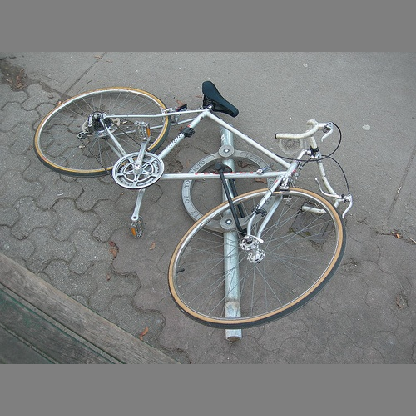

Uit annos: 1 , Berekend: 4
Gekozen: 4
1


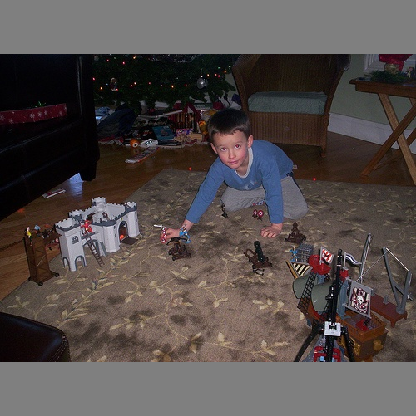

Uit annos: 3 , Berekend: 1
Gekozen: 1
Uit annos: 3 , Berekend: 1
Gekozen: 1
Uit annos: 3 , Berekend: 1
Gekozen: 1
4


In [5]:
# Setting device
device = torch.device('cpu')
if torch.cuda.is_available():
    print('CUDA enabled')
    device = torch.device('cuda')
else:
    print('CUDA not available')
    
# Path variables
network_path = 'cfg/yolo.py'
annos_path = 'data/VOCdevkit/VOC2007/Annotations/'
weights_path = 'weights/yolov2-voc.pt'

# Variables
anchorbox_threshold = 1.0

# Initialize network and load weigths
params = ln.engine.HyperParameters.from_file(network_path)
params.load(weights_path)

gradients_as_arr_list = []
#chosen_images = ['VOC2007/JPEGImages/000003']

for image in chosen_images:
    # New path
    new_path = annos_path + image.split('/')[-1] + '.xml'
    
    # Load annos
    annos = bb.io.load('anno_pascalvoc', new_path, ip.identify)
    
    # Run model
    params, img_tf, annos = ip.detect_new(params, annos, new_path , device)
    display(ip.utils.show_image(img_tf.data.cpu().numpy()[0]))

    # Vanilla backprop
    VBP = ip.backprop.VanillaBackprop(params, device)

    # Generate gradients
    gradients_as_arr = VBP.generate_gradients(params, img_tf, annos, device, anchorbox_threshold)
    for gradient in gradients_as_arr:
        gradients_as_arr_list.append(gradient)

max: 0.06423033 , min: -0.059900783
0.93436825 8.501684e-05
0.97915554 2.0703297e-05
0.9388596 0.0
1.0 0.0


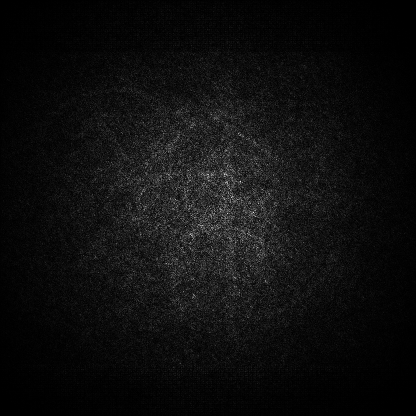

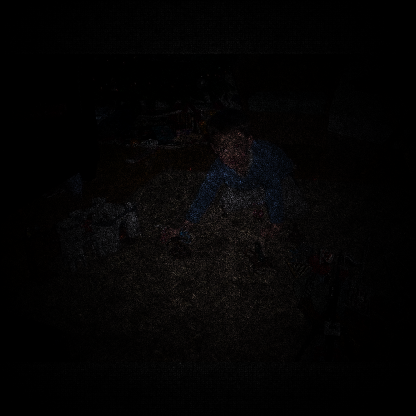

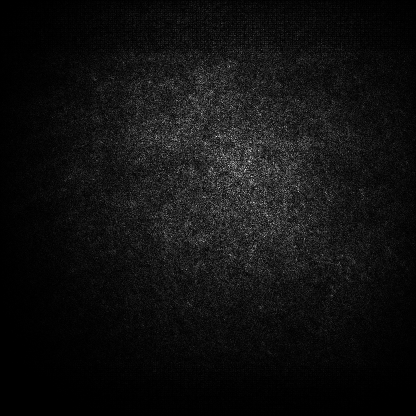

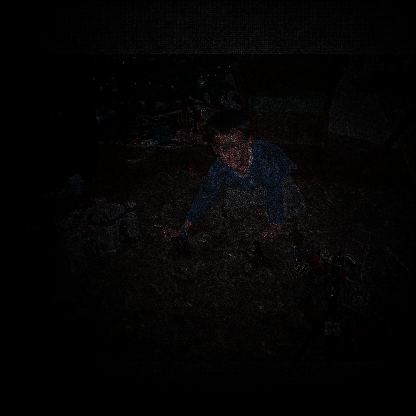

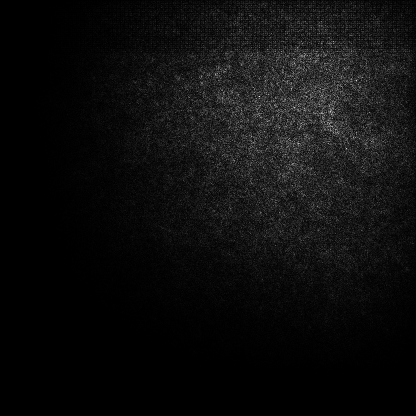

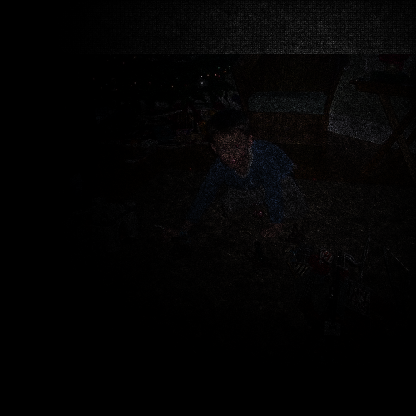

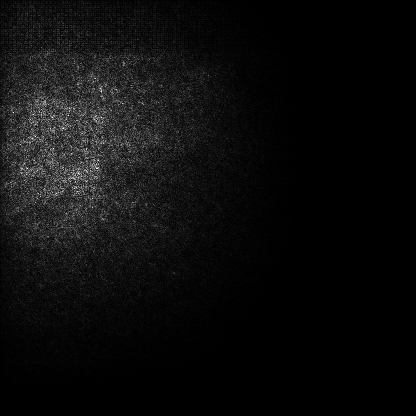

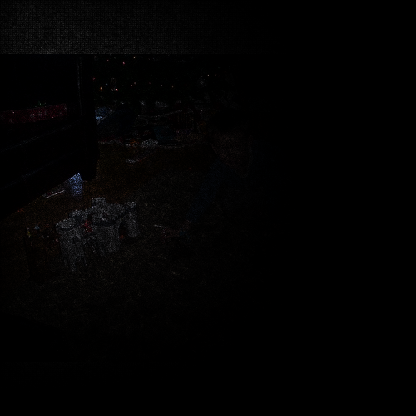

In [6]:
# Normalize to grayscale and show images
gradients_list = ip.utils.normalize(gradients_as_arr_list, True)
for gradient in gradients_list:
    display(ip.utils.show_image(gradient), ip.utils.show_image(gradient * img_tf.data.cpu().numpy()[0]))